In [1]:
import astropy.io.fits as fits
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import treecorr
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
# Load only necessary columns from the galaxy shape catalogue
shape_cat_path = '/n17data/mkilbing/astro/data/CFIS/v1.x/ShapePipe/v1.5.x/v1.5.3/unions_shapepipe_cut_struc_2024_v1.5.3.fits'
shapes = fits.open(shape_cat_path)[1].data


In [3]:
desi_lrg_ngc = fits.open('/home/murray/desi_data/LRG_NGC_clustering.dat.fits')[1].data
desi_lrg_sgc = fits.open('/home/murray/desi_data/LRG_SGC_clustering.dat.fits')[1].data

In [4]:
len( desi_lrg_ngc ) , len( desi_lrg_sgc )

(1476135, 662492)

In [5]:
# Combine the DESI north and south galaxy catalogues
galaxies = np.concatenate((desi_lrg_ngc, desi_lrg_sgc))

# Check the length of the combined catalogue
len(galaxies)

2138627

In [6]:

randoms_ngc = fits.open('/n17data/murray/desi_data/LRG_NGC_0_clustering.ran.fits')[1].data
randoms_sgc = fits.open('/n17data/murray/desi_data/LRG_SGC_0_clustering.ran.fits')[1].data

In [7]:
# Combine the DESI north and south galaxy catalogues
randoms = np.concatenate((randoms_ngc, randoms_sgc))

# Check the length of the combined catalogue
len(randoms)

14349309

In [8]:
position_catalogue = treecorr.Catalog( ra=galaxies['RA'], 
                                       dec=galaxies['DEC'], 
                                       w=galaxies['WEIGHT'],
                                       ra_units='deg', dec_units='deg')

In [9]:
random_position_catalogue = treecorr.Catalog( ra=randoms['RA'], 
                                       dec=randoms['DEC'], 
                                       w=randoms['WEIGHT'],
                                       ra_units='deg', dec_units='deg')

In [10]:
shape_catalogue = treecorr.Catalog(ra=shapes['RA'],
                                    dec=shapes['Dec'], 
                                    g1=shapes['e1'], 
                                    g2=shapes['e2'],
                                    w=shapes['w_iv'],
                                    ra_units='deg', dec_units='deg')

In [11]:
# Define the parameters for the correlation function
min_sep = 0.5  # Minimum separation in Mpc
max_sep = 200  # Maximum separation in Mpc
nbins = 40     # Number of bins
bin_slop = 0.1 # Bin slop

In [12]:
def process_ng_rpar_bin( shape_catalogue , position_catalogue , random_position_catalogue , min_sep, max_sep, nbins , bin_type = 'Linear' ):

    # Create the NNCorrelation objects
    ng = treecorr.NGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, bin_type=bin_type , sep_units='deg') 
    rg = treecorr.NGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, bin_type=bin_type , sep_units='deg') 

    # Process the position and random catalogues
    ng.process(position_catalogue, shape_catalogue , metric='Euclidean')
    #rg.process(random_position_catalogue, shape_catalogue, metric='Euclidean')

    return ng

In [13]:
# Define the parameters for the correlation function
min_sep = 0.1  # Minimum separation in Deg?
max_sep = 2  # Maximum separation in Deg?
nbins = 40     # Number of bins

In [14]:
ng = process_ng_rpar_bin( shape_catalogue , 
                          position_catalogue , 
                          random_position_catalogue ,
                          min_sep, 
                          max_sep, 
                          nbins , 
                          bin_type = 'Log' )

In [15]:
np.save('lensing_xi_p.npy', ng.xi)
np.save('lensing_xi_x.npy', ng.xi_im)
np.save('lensing_r.npy', ng.meanr)
np.save('lensing_var_xi.npy', ng.varxi )

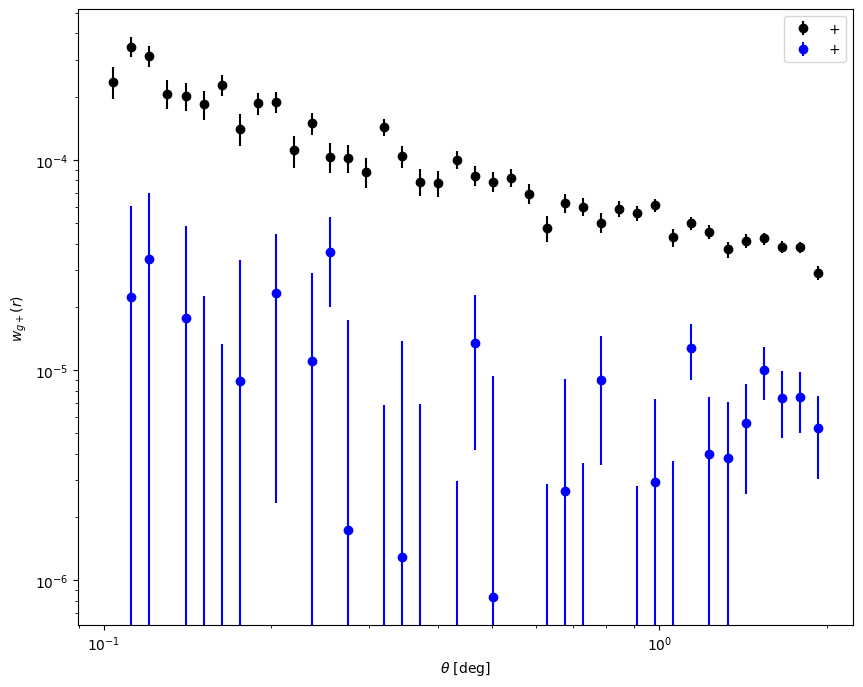

In [22]:
plt.figure(figsize=(10, 8))
plt.errorbar( ng.meanr, ng.xi, yerr=ng.varxi**0.5, fmt='ko', label='$+$')
plt.errorbar( ng.meanr, ng.xi_im, yerr=ng.varxi**0.5, fmt='bo', label='$+$')
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel('$w_{g+}(r)$')
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [ ]:
# Create SkyCoord objects for matching
galaxy_coords = coord.SkyCoord(ra=galaxies['RA']*u.degree, dec=galaxies['DEC']*u.degree)
shape_coords = coord.SkyCoord(ra=shapes['RA']*u.degree, dec=shapes['Dec']*u.degree)

# Perform the matching
idx, d2d, d3d = galaxy_coords.match_to_catalog_sky(shape_coords)

In [ ]:
# Apply a maximum separation criterion (e.g., 1 arcsecond)
max_sep = 1 * u.arcsec
matches = d2d < max_sep

In [ ]:
temp_max = 50
theta_bins = np.linspace( 0 , temp_max , 100 )
theta_cents = ( theta_bins[1:] + theta_bins[:-1] )/2.
counts, _ = np.histogram( d2d.arcsec[ d2d.arcsec < temp_max ] , bins = theta_bins )

In [ ]:
# Plot the histogram
plt.plot( theta_cents , counts )
plt.xlabel('Separation (arcseconds)')
plt.ylabel('Number of Matches')
plt.title('Histogram of Separations Between Catalogues')
plt.show()

In [ ]:
len( galaxies['RA'][matches] )

In [ ]:
# Filter the matched catalogues
matched_galaxy_ra = galaxies['RA'][matches]
matched_galaxy_dec = galaxies['DEC'][matches]
matched_galaxy_redshift = galaxies['Z'][matches]
matched_shape_ra = shapes['RA'][idx[matches]]
matched_shape_dec = shapes['Dec'][idx[matches]]
matched_shape_e1 = shapes['e1'][idx[matches]]
matched_shape_e2 = shapes['e2'][idx[matches]]
matched_shape_w = shapes['w_iv'][idx[matches]]

In [ ]:
# Create a new FITS table with the matched columns
cols = [
    fits.Column(name='RA', format='E', array=matched_galaxy_ra),
    fits.Column(name='Dec', format='E', array=matched_galaxy_dec),
    fits.Column(name='e1', format='E', array=matched_shape_e1),
    fits.Column(name='e2', format='E', array=matched_shape_e2),
    fits.Column(name='w_iv', format='E', array=matched_shape_w),
    fits.Column(name='galaxy_RA', format='E', array=matched_galaxy_ra),
    fits.Column(name='galaxy_Dec', format='E', array=matched_galaxy_dec),
    fits.Column(name='redshift', format='E', array=matched_galaxy_redshift)
]

hdu = fits.BinTableHDU.from_columns(cols)
hdu.writeto('unions_desi_lrg_catalogue.fits', overwrite=True)

In [8]:
shape_position_catalogue = fits.open('unions_desi_lrg_catalogue.fits')[1].data
len( shape_position_catalogue )

In [9]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM( 70 , 0.3 )

In [10]:
ra = 'Ra'
dec = 'DEC'
redshift = 'redshift'

In [11]:
import healpy as hp

In [12]:
# remove random shapes and positions outside of the survey footprints
# Convert RA, Dec to HEALPix pixel indices
nside = 128
pixels_positions = hp.ang2pix(nside, galaxies['RA'], galaxies['DEC'] , lonlat=True)
pixels_shapes = hp.ang2pix(nside,  shape_position_catalogue[ra], shape_position_catalogue[dec] , lonlat=True)
#pixels_unions_shapes = hp.ang2pix(nside,  shapes['Ra'], shapes['Dec'] , lonlat=True)
pixels_random_positions = hp.ang2pix(nside,  randoms['RA'], randoms['DEC'] , lonlat=True)

# Create HEALPix count maps
position_map = np.bincount(pixels_positions, minlength=hp.nside2npix(nside))
shape_map = np.bincount(pixels_shapes, minlength=hp.nside2npix(nside))
#unions_shape_map = np.bincount(pixels_unions_shapes, minlength=hp.nside2npix(nside))
random_position_map = np.bincount(pixels_random_positions, minlength=hp.nside2npix(nside))

# Create a mask: pixels with at least one object
position_mask = (position_map > 0) 
shape_mask = (shape_map>0) 

In [13]:
hp.mollview( position_map , coord ='E' )

In [14]:
hp.mollview( shape_mask , coord ='E' )

In [15]:
# hp.mollview( unions_shape_map, coord ='E' )

In [16]:
hp.mollview( random_position_map , coord ='E' )

In [17]:
plt.figure()
plt.hist( galaxies['Z'] ,100,histtype='step',density=True,label='positions')
plt.hist( randoms['Z'] ,100,histtype='step',density=True,label='eboss randoms')
plt.hist( shape_position_catalogue['redshift'],100,histtype='step',density=True,label='shapes')
# plt.hist(random_positions[redshift],100,histtype='step',density=True,label='Random positions',lw=2,alpha=0.5,color='C0')
# plt.hist(random_shapes[redshift],100,histtype='step',density=True,label='Random shapes',lw=2,alpha=0.5,color='C1')
plt.xlabel('redshift')
plt.ylabel('n')
plt.legend()


plt.figure()
plt.hist(np.sin(np.deg2rad(galaxies['DEC'])),100,histtype='step',density=True,label='positions')
#plt.hist(np.sin(np.deg2rad(shape_position_catalogue['Dec'])),100,histtype='step',density=True,label='shapes')
plt.hist(np.sin(np.deg2rad(randoms['DEC'])),100,histtype='step',density=True,label='Random positions',lw=2,alpha=0.5,color='C0')
plt.xlabel('sin(dec)')
plt.ylabel('n')
plt.legend()

plt.figure()
plt.hist(galaxies['RA'],100,histtype='step',density=True,label='positions')
#plt.hist(shape_position_catalogue['RA'],100,histtype='step',density=True,label='shapes')
plt.hist(randoms['RA'],100,histtype='step',density=True,label='Random positions',lw=2,alpha=0.5,color='C0')
plt.xlabel('ra')
plt.ylabel('n')
plt.legend()

In [18]:
import pandas as pd

In [19]:
galaxies

In [20]:
# Extract only 1D columns from the galaxy sample
columns_to_use = ['RA', 'DEC', 'Z',  'WEIGHT']
positions = pd.DataFrame({col: galaxies[col] for col in columns_to_use})

In [21]:
# Create the DataFrame
shapes = pd.DataFrame.from_records( shape_position_catalogue )

In [22]:
random_positions = pd.DataFrame.from_records( randoms )

In [23]:
positions.shape, shapes.shape, random_positions.shape

In [24]:
positions[redshift] = positions['Z']
positions['w'] = np.ones( len( positions ))
shapes['w'] = shapes['w_iv']
shapes['DEC'] = shapes['Dec']
random_positions[redshift] = random_positions['Z']


In [25]:
#random_positions = random_positions.iloc[::5].copy()

In [26]:
len( randoms ) / len( random_positions )

In [27]:
d = 'd'

positions.loc[:,d] = cosmo.comoving_distance(positions[redshift]).value
shapes.loc[:,d]    = cosmo.comoving_distance(shapes[redshift]).value

random_positions[d] = cosmo.comoving_distance(random_positions[redshift]).value

In [28]:
np.min( positions['d'])

In [29]:
positions['x'] = positions[d]*np.cos(np.deg2rad(positions['DEC']))*np.cos(np.deg2rad(positions['RA']))
positions['y'] = positions[d]*np.cos(np.deg2rad(positions['DEC']))*np.sin(np.deg2rad(positions['RA']))
positions['z'] = positions[d]*np.sin(np.deg2rad(positions['DEC']))

shapes['x'] = shapes[d]*np.cos(np.deg2rad(shapes['DEC']))*np.cos(np.deg2rad(shapes['RA']))
shapes['y'] = shapes[d]*np.cos(np.deg2rad(shapes['DEC']))*np.sin(np.deg2rad(shapes['RA']))
shapes['z'] = shapes[d]*np.sin(np.deg2rad(shapes['DEC']))

In [30]:
shapes['e1'].values

In [31]:
num_nans = shapes['e1'].isna().sum()
print(f"Number of NaNs: {num_nans}")


In [32]:
num_nans = shapes['e2'].isna().sum()
print(f"Number of NaNs: {num_nans}")

In [33]:
num_nans = shapes['w'].isna().sum()
print(f"Number of NaNs: {num_nans}")

In [34]:
position_catalogue = treecorr.Catalog( x=positions['x'], 
                                       y=positions['y'], 
                                       z=positions['z'],
                                       w=positions['w'])
shape_catalogue = treecorr.Catalog( x=shapes['x'], 
                                    y=shapes['y'], 
                                    z=shapes['z'], 
                                    g1 = shapes['e1'],
                                    g2 = shapes['e2'], 
                                    w=shapes['w'])


In [35]:
e = np.sqrt( shapes['e1']**2 + shapes['e2']**2 )

stick_catalogue = treecorr.Catalog( x=shapes['x'], 
                                    y=shapes['y'], 
                                    z=shapes['z'], 
                                    g1 = shapes['e1'] / e ,
                                    g2 = shapes['e2'] / e , 
                                    w= np.ones( shapes['w'].shape ) )

In [36]:
random_positions['x'] = random_positions[d]*np.cos(np.deg2rad(random_positions['DEC']))*np.cos(np.deg2rad(random_positions['RA']))
random_positions['y'] = random_positions[d]*np.cos(np.deg2rad(random_positions['DEC']))*np.sin(np.deg2rad(random_positions['RA']))
random_positions['z'] = random_positions[d]*np.sin(np.deg2rad(random_positions['DEC']))

In [37]:
random_position_catalogue = treecorr.Catalog( x=random_positions['x'], 
                                              y=random_positions['y'], 
                                              z=random_positions['z'])

In [38]:
# Function to process a single rpar bin
def process_rpar_bin(min_rpar, max_rpar , min_sep, max_sep, nbins , bin_slop  ):
    print('Running between rpar =', min_rpar, 'and rpar =', max_rpar)

    # Create the NNCorrelation objects
    nn = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type='Linear' , bin_slop = bin_slop ) 
    rr = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type='Linear' , bin_slop = bin_slop ) 
    dr = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type='Linear' , bin_slop = bin_slop )

    # Process the position and random catalogues
    nn.process(position_catalogue, position_catalogue, metric='Rperp')
    rr.process(random_position_catalogue, random_position_catalogue, metric='Rperp')
    dr.process(position_catalogue, random_position_catalogue, metric='Rperp')

    # Calculate the Landy-Szalay estimator
    xi, varxi = nn.calculateXi(rr=rr, dr=dr)
    r = np.exp(nn.meanlogr)
    sig = np.sqrt(varxi)

    return xi, r

In [ ]:
# Define the range and number of bins for rpar
rpar_bins = np.linspace(-200, 200, 41 )  

# Define the parameters for the correlation function
min_sep = 0.5  # Minimum separation in Mpc
max_sep = 200  # Maximum separation in Mpc
nbins = 40     # Number of bins
bin_slop = 0.1 # Bin slop

In [ ]:
# Initialize lists to store results
xi_results = []
r_results = []

# Iterate over rpar bins
for i in range(len(rpar_bins) - 1):

    min_rpar = rpar_bins[i]
    max_rpar = rpar_bins[i + 1]

    xi , r = process_rpar_bin( min_rpar, max_rpar , min_sep , max_sep , nbins , bin_slop )

    # Store the results
    xi_results.append(xi)
    r_results.append(r)

In [ ]:
xi_results = np.array(xi_results)

In [ ]:
xi_results.shape

In [ ]:
plt.imshow( np.log10( np.abs( xi_results ) ) )
plt.colorbar()

In [ ]:
xi_results.shape

In [ ]:
from scipy.ndimage import gaussian_filter

sigma = 1

# Apply Gaussian smoothing
smoothed_xi_results = gaussian_filter(xi_results, sigma= sigma )

plt.figure(figsize=(10, 5))
plt.imshow( np.log10( smoothed_xi_results ), extent=[0, 200, -200, 200])
plt.colorbar()


In [ ]:
r.shape

In [ ]:
# Assuming r_perp_bins and r_par_bins are defined
r_perp_cents = r
r_par_cents = ( rpar_bins[1:] + rpar_bins[:-1] )/2.

# Flatten the xi_results and r_results arrays
xi_flat = np.array(xi_results).flatten()
r_perp_flat = np.array([r_perp_cents] * len(r_par_cents)).flatten()
r_par_flat = np.array([[r_par] * len(r_perp_cents) for r_par in r_par_cents]).flatten()



In [ ]:
r_par_flat.shape, r_perp_flat.shape, xi_flat.shape

In [ ]:
# Calculate s for each pair of (r_perp, r_par)
s = np.sqrt(r_perp_flat**2 + r_par_flat**2)

In [ ]:
np.min( s ) , np.max( s )

In [ ]:
# Calculate s for each pair of (r_perp, r_par)
s = np.sqrt(r_perp_flat**2 + r_par_flat**2)

# Define bins for s
s_bins = np.linspace( 50 , 250 , 40)

# Initialize arrays to store the results
xi_s = np.zeros(len(s_bins) - 1)
var_xi_s = np.zeros(len(s_bins) - 1)
counts = np.zeros(len(s_bins) - 1)

# Bin the results by s and calculate the radial averages and variances
for i in range(len(s_bins) - 1):
    mask = (s >= s_bins[i]) & (s < s_bins[i + 1])
    if np.any(mask):  # Check if there are any elements in the mask
        xi_s[i] = np.mean(xi_flat[mask])
        var_xi_s[i] = np.var(xi_flat[mask])
        counts[i] = np.sum(mask)

# Handle cases where there are no counts in a bin
xi_s[counts == 0] = np.nan
var_xi_s[counts == 0] = np.nan

In [ ]:
s_cents = ( s_bins[1:] + s_bins[:-1] )/2.

In [ ]:
plt.errorbar( s_cents , xi_s * s_cents**2, fmt='o' , yerr = var_xi_s**0.5  * s_cents**2 / counts**0.5 )
plt.xlabel('s')
plt.ylabel('Xi(s)')
plt.title('Radial Averages of Xi(s)')
plt.xlim( 10 , 200 )
plt.ylim( -0.01 , 0.03 * 100**2 )
plt.show()

In [ ]:
plt.errorbar( s_cents , xi_s , fmt='o' , yerr = var_xi_s**0.5 / counts**0.5 )
plt.xlabel('s')
plt.ylabel('Xi(s)')
plt.title('Radial Averages of Xi(s)')
plt.xlim( 50 , 200 )
#plt.ylim( -0.01 , 0.03  )
plt.show()

In [ ]:
colors = plt.cm.coolwarm(np.linspace(0, 1, len(xi_results)))

for xi, color in zip(xi_results, colors):
    plt.plot(r, xi, color=color)
    plt.yscale('log')

plt.show()

In [ ]:
def process_ng_rpar_bin( shape_catalogue , min_rpar, max_rpar , min_sep, max_sep, nbins , bin_type = 'Linear' ):
    print('Running between rpar =', min_rpar, 'and rpar =', max_rpar)

    # Create the NNCorrelation objects
    ng = treecorr.NGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type=bin_type) 
    rg = treecorr.NGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type=bin_type) 

    # Process the position and random catalogues
    ng.process(position_catalogue, shape_catalogue , metric='Rperp')
    rg.process(random_position_catalogue, shape_catalogue, metric='Rperp')

    # Calculate the Landy-Szalay estimator
    xi_p , xi_x , _ = ng.calculateXi( rg = rg)
    r = np.exp(ng.meanlogr)

    return r , xi_p , xi_x

In [40]:
# Define the range and number of bins for rpar
rpar_bins = np.linspace(-200, 200, 201 )  

# Define the parameters for the correlation function
min_sep = 0.5  # Minimum separation in Mpc
max_sep = 200  # Maximum separation in Mpc
nbins = 100     # Number of bins
bin_slop = 0.1 # Bin slop

In [46]:
r , w_xi_p , w_xi_x = process_ng_rpar_bin( shape_catalogue , -30, 30 , min_sep , 200 , 20, bin_type='Log' )

In [47]:
h = 0.7

In [50]:
plt.plot( r  * h, w_xi_p )
plt.plot( r  * h, w_xi_x )
plt.xscale('log')
plt.xlabel('s')
plt.ylabel(r'$\xi_{g+}(s)$')
plt.show()

In [52]:
plt.plot( r  * h, -r*w_xi_p )
plt.plot( r  * h, -r*w_xi_x )
plt.xscale('log')
plt.xlabel('s')
plt.ylabel(r'$\xi_{g+}(s)$')
plt.show()

In [51]:
plt.plot( r  * h, -w_xi_p )
plt.plot( r  * h, -w_xi_x )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('s')
plt.ylabel(r'$\xi_{g+}(s)$')
plt.show()

In [49]:
np.save('lrg_w_xi_p.npy', w_xi_p )
np.save('lrg_w_xi_x.npy', w_xi_x )
np.save('lrg_w_r.npy', r )

In [ ]:
# Initialize lists to store results
xi_gn_p_results = []
xi_gn_x_results = []
r_results = []

# Iterate over rpar bins
for i in range(len(rpar_bins) - 1):

    min_rpar = rpar_bins[i]
    max_rpar = rpar_bins[i + 1]

    r , xi_p , xi_x = process_ng_rpar_bin( shape_catalogue , min_rpar, max_rpar , min_sep , max_sep , nbins )

    # Store the results
    xi_gn_p_results.append( xi_p )
    xi_gn_x_results.append( xi_x )
    r_results.append(r)

In [ ]:
xi_gn_p_results = np.array(xi_gn_p_results)
xi_gn_x_results = np.array(xi_gn_x_results)

In [ ]:
plt.figure( figsize = ( 10 , 5 ))
plt.subplot(121)
plt.imshow( np.log10( np.abs( xi_gn_p_results ) ) , extent = [ 0 , 200 , -200 , 200 ] )
plt.colorbar()

plt.subplot(122)
plt.imshow( np.log10( np.abs( xi_gn_x_results ) ) , extent = [ 0 , 200 , -200 , 200 ] )
plt.colorbar()

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(xi_gn_p_results, extent=[0, 200, -200, 200])
plt.colorbar()

plt.subplot(122)
plt.imshow(xi_gn_x_results, extent=[0, 200, -200, 200])
plt.colorbar()

In [ ]:
# np.save('lrg_xi_gn_p_results',xi_gn_p_results)
# np.save('lrg_xi_gn_x_results',xi_gn_x_results)

In [2]:
xi_gn_p_results = np.load('lrg_xi_gn_p_results.npy')
xi_gn_x_results = np.load('lrg_xi_gn_x_results.npy')

In [3]:
from scipy.ndimage import gaussian_filter

sigma = 1.5

# Apply Gaussian smoothing
smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma= sigma )
smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma= sigma )

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(smoothed_xi_gn_p_results, extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

plt.subplot(122)
plt.imshow(smoothed_xi_gn_x_results, extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

In [12]:
sigma = 1.5

# Apply Gaussian smoothing
smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma= sigma )
smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma= sigma )

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.contourf( np.log10( np.abs(  smoothed_xi_gn_p_results )), extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

plt.subplot(122)
plt.contourf( np.log10( np.abs( smoothed_xi_gn_x_results )), extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

In [13]:
sigma = 1.5

# Apply Gaussian smoothing
smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma= sigma )
smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma= sigma )

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.contourf( ( np.abs(  smoothed_xi_gn_p_results )), extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

plt.subplot(122)
plt.contourf( ( np.abs( smoothed_xi_gn_x_results )), extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

In [15]:
xi_gn_p_results.shape

In [14]:
sigma = 1.5

# Apply Gaussian smoothing
smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma= sigma )
smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma= sigma )

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.contourf( ( (  smoothed_xi_gn_p_results )), extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

plt.subplot(122)
plt.contourf( ( ( smoothed_xi_gn_x_results )), extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

In [17]:
xi_gn_p_avg.shape

In [ ]:
# Reflect the array about r_par = 0
xi_gn_p_reflected = xi_gn_p_results[::-1, :]

# Sum the original and reflected arrays
xi_gn_p_summed = xi_gn_p_results + xi_gn_p_reflected

# Divide by 2 to get the average
xi_gn_p_avg = xi_gn_p_summed / 2


In [24]:
sigma = 3

# Apply Gaussian smoothing
smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_avg, sigma= sigma )
smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma= sigma )

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.contourf( ( (  smoothed_xi_gn_p_results )), extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( 0 , 60 )
plt.colorbar()

plt.subplot(122)
plt.contourf( ( ( smoothed_xi_gn_x_results )), extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( 0 , 60 )
plt.colorbar()

In [ ]:
sigma = 1.5

# Apply Gaussian smoothing
smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma= sigma )
smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma= sigma )

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(np.log(-smoothed_xi_gn_p_results ), extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

plt.subplot(122)
plt.imshow(np.log(-smoothed_xi_gn_x_results ), extent=[0, 200, -200, 200])
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

In [ ]:
sigma = 2.5

# Apply Gaussian smoothing
smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma= sigma )
smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma= sigma )

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(smoothed_xi_gn_p_results, extent=[0, 200, -200, 200] , vmin =-1e-3, vmax=1e-3 )
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

plt.subplot(122)
plt.imshow(smoothed_xi_gn_x_results, extent=[0, 200, -200, 200] , vmin =-1e-3, vmax=1e-3 )
plt.xlim(  0 , 60 )
plt.ylim( -60 , 60 )
plt.colorbar()

In [ ]:
from scipy.ndimage import gaussian_filter

sigma = 2

# Apply Gaussian smoothing
smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma= sigma )
smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma= sigma )

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(smoothed_xi_gn_p_results, extent=[0, 200, -200, 200])
plt.colorbar()

plt.subplot(122)
plt.imshow(smoothed_xi_gn_x_results, extent=[0, 200, -200, 200])
plt.colorbar()

In [ ]:
# # Initialize lists to store results
# sticks_xi_gn_p_results = []
# sticks_xi_gn_x_results = []
# r_results = []

# # Iterate over rpar bins
# for i in range(len(rpar_bins) - 1):

#     min_rpar = rpar_bins[i]
#     max_rpar = rpar_bins[i + 1]

#     r , xi_p , xi_x = process_ng_rpar_bin( stick_catalogue , min_rpar, max_rpar , min_sep , max_sep , nbins )

#     # Store the results
#     sticks_xi_gn_p_results.append( xi_p )
#     sticks_xi_gn_x_results.append( xi_x )
#     r_results.append(r)

In [ ]:
r = np.linspace( 0.5 , 200 , 100 )

In [ ]:
# Assuming r_perp_bins and r_par_bins are defined
r_perp_cents = r = np.linspace( 0.5 , 200 , 100 )
r_par_cents = ( rpar_bins[1:] + rpar_bins[:-1] )/2.

# Flatten the xi_results and r_results arrays
xi_gn_p_flat = np.array(xi_gn_p_results).flatten()
xi_gn_x_flat = np.array(xi_gn_x_results).flatten()

# sticks_xi_gn_p_flat = np.array(sticks_xi_gn_p_results).flatten()
# sticks_xi_gn_x_flat = np.array(sticks_xi_gn_x_results).flatten()


r_perp_flat = np.array([r_perp_cents] * len(r_par_cents)).flatten()
r_par_flat = np.array([[r_par] * len(r_perp_cents) for r_par in r_par_cents]).flatten()

In [ ]:
# Calculate s for each pair of (r_perp, r_par)
s = np.sqrt(r_perp_flat**2 + r_par_flat**2)

# Define bins for s
s_bins = np.linspace(0.5, 200, 30 )
s_bins = np.logspace( np.log10( 0.1 ) , np.log10( 200 ) , 45 )
s_cents = (s_bins[1:] + s_bins[:-1]) / 2.

# Initialize arrays to store the results
xi_p_s = np.zeros(len(s_bins) - 1)
var_xi_p_s = np.zeros(len(s_bins) - 1)
counts_p = np.zeros(len(s_bins) - 1)

xi_x_s = np.zeros(len(s_bins) - 1)
var_xi_x_s = np.zeros(len(s_bins) - 1)
counts_x = np.zeros(len(s_bins) - 1)

# Calculate theta
theta = np.degrees(np.arctan2(r_par_flat, r_perp_flat))

# Bin the results by s and calculate the radial averages and variances
for i in range(len(s_bins) - 1):
    mask = (s >= s_bins[i]) & (s < s_bins[i + 1])
    if np.any(mask):  # Check if there are any elements in the mask
        xi_p_s[i] = np.mean(xi_gn_p_flat[mask])
        var_xi_p_s[i] = np.var(xi_gn_p_flat[mask])
        counts_p[i] = np.sum(mask)

        xi_x_s[i] = np.mean(xi_gn_x_flat[mask])
        var_xi_x_s[i] = np.var(xi_gn_x_flat[mask])
        counts_x[i] = np.sum(mask)

# Handle cases where there are no counts in a bin
xi_p_s[counts_p == 0] = np.nan
var_xi_p_s[counts_p == 0] = np.nan

xi_x_s[counts_x == 0] = np.nan
var_xi_x_s[counts_x == 0] = np.nan

# Calculate the average within the specified theta ranges and r_perp >= 5
theta_mask = (((theta > -45) & (theta < 45)) | ((theta > 135) & (theta < 225))) & (r_perp_flat >= 5)

xi_p_s_theta = np.zeros(len(s_bins) - 1)
var_xi_p_s_theta = np.zeros(len(s_bins) - 1)
counts_p_theta = np.zeros(len(s_bins) - 1)

xi_x_s_theta = np.zeros(len(s_bins) - 1)
var_xi_x_s_theta = np.zeros(len(s_bins) - 1)
counts_x_theta = np.zeros(len(s_bins) - 1)

for i in range(len(s_bins) - 1):
    mask = (s >= s_bins[i]) & (s < s_bins[i + 1]) & theta_mask 
    if np.any(mask):  # Check if there are any elements in the mask
        xi_p_s_theta[i] = np.mean(xi_gn_p_flat[mask])
        var_xi_p_s_theta[i] = np.var(xi_gn_p_flat[mask])
        counts_p_theta[i] = np.sum(mask)

        xi_x_s_theta[i] = np.mean(xi_gn_x_flat[mask])
        var_xi_x_s_theta[i] = np.var(xi_gn_x_flat[mask])
        counts_x_theta[i] = np.sum(mask)

# Handle cases where there are no counts in a bin
xi_p_s_theta[counts_p_theta == 0] = np.nan
var_xi_p_s_theta[counts_p_theta == 0] = np.nan

xi_x_s_theta[counts_x_theta == 0] = np.nan
var_xi_x_s_theta[counts_x_theta == 0] = np.nan

In [ ]:
h =0.7

In [ ]:
#plt.errorbar( s_cents * h , xi_p_s * s_cents**2, fmt='o' , yerr = var_xi_p_s**0.5  * s_cents**2 / counts_x**0.5 )
plt.errorbar( s_cents * h , -xi_p_s_theta, fmt='ko' , yerr = var_xi_p_s**0.5  / counts_x**0.5  )
#plt.plot(s_cents * h, np.zeros(s_cents.shape), 'k--' )
plt.axvline(x=150 * h, color='r', linestyle='--', label='BAO scale')

# plt.errorbar( s_cents , -xi_x_s * s_cents**2, fmt='o' , yerr = var_xi_x_s**0.5  * s_cents**2 / counts_p**0.5 )
#plt.errorbar( s_cents * h , -sticks_xi_p_s * s_cents**2, fmt='o' , yerr = var_xi_p_s**0.5  * s_cents**2 / counts_x**0.5 )
plt.xlabel('s')
plt.ylabel(r'$ \xi_{g+}(s)$')
#plt.xlim( 50 , 150 )
#plt.ylim( -12 , 6 )
#plt.ylim( -10 , 20 )
#plt.ylim( -0.01 , 0.03 * 100**2 )
plt.xscale('log')
plt.yscale('log')


In [ ]:
#plt.errorbar( s_cents * h , xi_p_s * s_cents**2, fmt='o' , yerr = var_xi_p_s**0.5  * s_cents**2 / counts_x**0.5 )
plt.errorbar( s_cents * h , xi_p_s_theta * s_cents**2, fmt='ko' , yerr = var_xi_p_s**0.5  * s_cents**2 / counts_x**0.5  )
#plt.plot(s_cents * h, np.zeros(s_cents.shape), 'k--' )
plt.axvline(x=150 * h, color='r', linestyle='--', label='BAO scale')

# plt.errorbar( s_cents , -xi_x_s * s_cents**2, fmt='o' , yerr = var_xi_x_s**0.5  * s_cents**2 / counts_p**0.5 )
#plt.errorbar( s_cents * h , -sticks_xi_p_s * s_cents**2, fmt='o' , yerr = var_xi_p_s**0.5  * s_cents**2 / counts_x**0.5 )
plt.xlabel('s')
plt.ylabel(r'$s^2 \xi_{g+}(s)$')
plt.xlim( 50 , 150 )
plt.ylim( -12 , 6 )
#plt.ylim( -10 , 20 )
#plt.ylim( -0.01 , 0.03 * 100**2 )
plt.show()

In [ ]:
plt.errorbar( s_cents * h , xi_p_s * s_cents**2, fmt='ko' , yerr = var_xi_p_s**0.5  * s_cents**2 / counts_x**0.5 )
#plt.plot(s_cents * h, np.zeros(s_cents.shape), 'k--' )
plt.axvline(x=150 * h, color='r', linestyle='--', label='BAO scale')

# plt.errorbar( s_cents , -xi_x_s * s_cents**2, fmt='o' , yerr = var_xi_x_s**0.5  * s_cents**2 / counts_p**0.5 )
#plt.errorbar( s_cents * h , -sticks_xi_p_s * s_cents**2, fmt='o' , yerr = var_xi_p_s**0.5  * s_cents**2 / counts_x**0.5 )
plt.xlabel('s')
plt.ylabel('Xi(s)')
plt.title('Radial Averages of Xi(s)')
plt.xlim( 50 , 150 )
plt.ylim( -12 , 6 )
#plt.ylim( -10 , 20 )
#plt.ylim( -0.01 , 0.03 * 100**2 )
plt.show()

In [ ]:
plt.errorbar(s_cents * h, -xi_p_s , fmt='o', yerr=var_xi_p_s**0.5 / counts_x**0.5 )
# plt.errorbar(s_cents, xi_s, fmt='o', yerr=var_xi_s**0.5 / counts**0.5, label='Xi_s(s)')
# plt.errorbar(s_cents, -xi_x_s, fmt='o', yerr=var_xi_x_s**0.5 / counts_p**0.5, label='Xi_x(s)')
plt.plot(s_cents * h, np.zeros(s_cents.shape), 'k--' )
plt.axvline(x=150 * h, color='r', linestyle='--', label='BAO scale')
plt.xlabel('s')
plt.ylabel(r'$\xi_{g+}(s)$')
#plt.xlim( 50 , 150 )
#plt.ylim( -0.002, 0.0008 )
plt.yscale('log')
#plt.ylim( -0.001, 0.0008 )
#plt.legend()
plt.show()

In [ ]:
plt.errorbar(s_cents * h, xi_p_s, fmt='o', yerr=var_xi_p_s**0.5 / counts_x**0.5 )
# plt.errorbar(s_cents, xi_s, fmt='o', yerr=var_xi_s**0.5 / counts**0.5, label='Xi_s(s)')
# plt.errorbar(s_cents, -xi_x_s, fmt='o', yerr=var_xi_x_s**0.5 / counts_p**0.5, label='Xi_x(s)')
plt.plot(s_cents * h, np.zeros(s_cents.shape), 'k--' )
plt.axvline(x=150 * h, color='r', linestyle='--', label='BAO scale')
plt.xlabel('s')
plt.ylabel(r'$\xi_{g+}(s)$')
plt.xlim( 50 , 150 )
plt.ylim( -0.0004, 0.0002 )
# plt.yscale('log')
#plt.legend()
plt.show()

In [ ]:
# Shear stuff
# Function to process a single rpar bin
def process_gg_rpar_bin( shape_catalogue , min_rpar, max_rpar , min_sep = min_sep, max_sep = max_sep, nbins = nbins):
    print('Running between rpar =', min_rpar, 'and rpar =', max_rpar)

    # Create the NNCorrelation objects
    gg = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type='Linear') 

    # Process the position and random catalogues
    gg.process(shape_catalogue, shape_catalogue, metric='Rperp')

    xip = gg.xip
    xim = gg.xim
    r = np.exp(gg.meanlogr)

    return r , xip , xim

In [ ]:
# Define the range and number of bins for rpar
rpar_bins = np.linspace(-200, 200, 201 )  

# Define the parameters for the correlation function
min_sep = 0.5  # Minimum separation in Mpc
max_sep = 200  # Maximum separation in Mpc
nbins = 100     # Number of bins
bin_slop = 0.1 # Bin slop

In [ ]:
# Initialize lists to store results
xi_gg_p_results = []
xi_gg_m_results = []
r_results = []

# Iterate over rpar bins
for i in range(len(rpar_bins) - 1):

    min_rpar = rpar_bins[i]
    max_rpar = rpar_bins[i + 1]

    r , xi_p , xi_m = process_gg_rpar_bin( shape_catalogue , min_rpar, max_rpar , min_sep , max_sep , nbins )

    # Store the results
    xi_gg_p_results.append( xi_p )
    xi_gg_m_results.append( xi_m )
    r_results.append(r)

In [ ]:
plt.figure( figsize = ( 10 , 5 ))
plt.subplot(121)
plt.imshow( ( xi_gg_p_results ) )
plt.colorbar()

plt.subplot(122)
plt.imshow( ( xi_gg_m_results ) )
plt.colorbar()

In [2]:
sigma = 2

# Apply Gaussian smoothing
smoothed_xi_gg_p_results = gaussian_filter(xi_gg_p_results, sigma= sigma )
smoothed_xi_gg_m_results = gaussian_filter(xi_gg_m_results, sigma= sigma )

image_lim = 100

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(smoothed_xi_gg_p_results, extent=[0, 200, -200, 200])
plt.xlim(  0 ,image_lim )
plt.ylim( -image_lim ,image_lim )
plt.colorbar()

plt.subplot(122)
plt.imshow(smoothed_xi_gg_m_results, extent=[0, 200, -200, 200])
plt.xlim(  0 ,image_lim )
plt.ylim( -image_lim ,image_lim )
plt.colorbar()

In [ ]:
# Flatten the xi_gg_p_results and xi_gg_m_results arrays
xi_gg_p_flat = np.array(xi_gg_p_results).flatten()
xi_gg_m_flat = np.array(xi_gg_m_results).flatten()

# Calculate s for each pair of (r_perp, r_par)
s = np.sqrt(r_perp_flat**2 + r_par_flat**2)

# Define bins for s
s_bins = np.linspace(5, 250, 20)
s_cents = (s_bins[1:] + s_bins[:-1]) / 2.

# Initialize arrays to store the results
xi_gg_p_s = np.zeros(len(s_bins) - 1)
var_xi_gg_p_s = np.zeros(len(s_bins) - 1)
counts_p = np.zeros(len(s_bins) - 1)

xi_gg_m_s = np.zeros(len(s_bins) - 1)
var_xi_gg_m_s = np.zeros(len(s_bins) - 1)
counts_m = np.zeros(len(s_bins) - 1)

# Bin the results by s and calculate the radial averages and variances
for i in range(len(s_bins) - 1):
    mask = (s >= s_bins[i]) & (s < s_bins[i + 1])
    if np.any(mask):  # Check if there are any elements in the mask
        xi_gg_p_s[i] = np.mean(xi_gg_p_flat[mask])
        var_xi_gg_p_s[i] = np.var(xi_gg_p_flat[mask])
        counts_p[i] = np.sum(mask)

        xi_gg_m_s[i] = np.mean(xi_gg_m_flat[mask])
        var_xi_gg_m_s[i] = np.var(xi_gg_m_flat[mask])
        counts_m[i] = np.sum(mask)

# Handle cases where there are no counts in a bin
xi_gg_p_s[counts_p == 0] = np.nan
var_xi_gg_p_s[counts_p == 0] = np.nan

xi_gg_m_s[counts_m == 0] = np.nan
var_xi_gg_m_s[counts_m == 0] = np.nan


In [ ]:
plt.errorbar( s_cents * h , xi_gg_m_s, fmt='o' , yerr = var_xi_gg_m_s**0.5 / counts_m**0.5 )
# plt.errorbar( s_cents , xi_s , fmt='o' , yerr = var_xi_s**0.5 / counts**0.5 )
# plt.errorbar( s_cents * h , xi_gg_p_s, fmt='o' , yerr = var_xi_gg_p_s**0.5 / counts_p**0.5 )

#plt.errorbar( s_cents , -xi_x_s, fmt='o' , yerr = var_xi_x_s**0.5 / counts_p**0.5 )
plt.plot( s_cents *h , np.zeros( s_cents.shape ) , 'k--')
plt.xlabel('s')
plt.ylabel('Xi(s)')
plt.title('Radial Averages of Xi(s)')
#plt.xlim( 5 * h , 250 * h )
plt.ylim( -0.0001 , 0.0001 ) 
#plt.yscale('log')
plt.show()

In [ ]:
plt.errorbar( s_cents * h , xi_gg_p_s, fmt='o' , yerr = var_xi_gg_m_s**0.5 / counts_m**0.5 )
# plt.errorbar( s_cents , xi_s , fmt='o' , yerr = var_xi_s**0.5 / counts**0.5 )
# plt.errorbar( s_cents * h , xi_gg_p_s, fmt='o' , yerr = var_xi_gg_p_s**0.5 / counts_p**0.5 )

#plt.errorbar( s_cents , -xi_x_s, fmt='o' , yerr = var_xi_x_s**0.5 / counts_p**0.5 )
plt.plot( s_cents *h , np.zeros( s_cents.shape ) , 'k--')
plt.xlabel('s')
plt.ylabel('Xi(s)')
plt.title('Radial Averages of Xi(s)')
#plt.xlim( 5 * h , 250 * h )
plt.ylim( -0.0001 , 0.0001 ) 
#plt.yscale('log')
plt.show()

In [ ]:
# Create the NNCorrelation objects
ng = treecorr.NGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar) 
rg = treecorr.NGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar) 

In [ ]:
# Process the position and random catalogues
ng.process( position_catalogue , shape_catalogue , metric ='Rperp' )
rg.process( random_position_catalogue , shape_catalogue, metric ='Rperp' )

In [ ]:
xi_p = ng.raw_xi
xim_p = ng.xi_im 

In [ ]:
# Plot the correlation function
plt.figure(figsize=(8, 6))
plt.plot(r, xi_p, label=r'$\Xi(s)$')
plt.plot(r, xim_p, label=r'$\Xi(s)$')
plt.xscale('log')
plt.xlabel('Separation (Mpc)')
plt.ylabel(r'$\Xi(s)$')
plt.title('Landy-Szalay Correlation Function $\Xi(s)$')
plt.legend()
plt.show()

In [ ]:
from ia_corr import compute_2p_corr

In [ ]:
# parameters related with bins
nbins = 10 # number of radial bins
rmin = 0.1 # minimum value for rp (r in case of the quadrupole)
rmax = 200. # maximum value for rp (r in case of the quadrupole)
pi_max = 15. # maximum value along l.o.s. (Pi) 
npi = 5 # number of bins in Pi
mubins = 10 # number of bins in mu
grid_resolution = 10 # Controls the resolution of the r,mu grid to compute the quadrupole, 
#you can lower this value for a faster computation but it's going to compute wgp2 only at larger radius

# Related to JK patches
NPatches = 15 #int(nbins**(3./2.))
print('Number of patches',NPatches)
# Other configuration parameters
ncores = 30 # Number of cores to run in parallel
slop = 0.1 # Resolution for treecorr
box = False # Indicates if the data corresponds to a box, otherwise it will assume a lightcone
exact_position = False # Indicates if the coordinates are exactly provided (e.g. simulated data 
# without any error added in the position). Otherwise it will assume that the positions are not
# exact and will use ra, dec to match the catalogues. If this parameter is set as True, it
# will neglect box and it will set it as False
sky_threshold = 1.0 # Threshold for matching the catalogues in arcsecond, used if exact_position
#is set to True.
grid_resolution = 10 # Resolution of the grid used to compute the quadrupole, a lower number will
#speed up the computation but reaches to larger radial distances.

In [ ]:
col_names = ['RA','DEC','d','e1','e2', 'w']

config = {'col_names': col_names,
          'nbins': nbins,
          'rmin': rmin,
          'rmax': rmax,
          'pi_max': pi_max,
          'npi': npi,
          'grid_resolution': grid_resolution,
          'mubins': mubins,
          'NPatches': NPatches,
          'ncores': ncores,
          'slop': slop,
          'box': box,
          'exact_position': exact_position,
          'sky_threshold': sky_threshold,
          'grid_resolution': grid_resolution
         }

In [ ]:
corr = compute_2p_corr(positions,shapes,random_positions,random_shapes,config)


In [ ]:
corr.compute_wgg()

In [ ]:
plt.errorbar(corr.wgg.rp,corr.wgg.xip,yerr=corr.wgg.std_from_cov,label=r'$w_{gg}[Mpc/h]²$',c='lightcoral')
# plt.errorbar(corr.wgp.rp,corr.wgp.xip,yerr=corr.wgp.std_from_cov,label=r'$w_{g+}[Mpc/h]²$',c='C3')
# plt.errorbar(corr.wgp2.r,corr.wgp2.xip,yerr=corr.wgp2.std_from_cov,label=r'$w_{g+,2}[Mpc/h]²$',c='brown')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$w[Mpc/h]²$',fontsize=14)
plt.xlabel(r'$r(_p) [Mpc/h]$',fontsize=14)
plt.legend(frameon=False)

In [ ]:
corr.compute_wgp()

In [ ]:
# plt.errorbar(corr.wgg.rp,
#              corr.wgg.xip,yerr=corr.wgg.std_from_cov,label=r'$w_{gg}[Mpc/h]²$',c='lightcoral')
plt.errorbar( corr.wgp.rp,
              -corr.wgp.xip,
              yerr=corr.wgp.std_from_cov,label=r'$w_{g+}[Mpc/h]²$',c='C3')
plt.errorbar( corr.wgp.rp,
              corr.wgx.xip,
              yerr=corr.wgx.std_from_cov,label=r'$w_{gx}[Mpc/h]²$',c='b')
# plt.errorbar(corr.wgp.rp,-corr.wgp.xip,yerr=corr.wgp.std_from_cov,label=r'$w_{g+}[Mpc/h]²$',c='C3')
# plt.errorbar(corr.wgp2.r,corr.wgp2.xip,yerr=corr.wgp2.std_from_cov,label=r'$w_{g+,2}[Mpc/h]²$',c='brown')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$w[Mpc/h]²$',fontsize=14)
plt.xlabel(r'$r(_p) [Mpc/h]$',fontsize=14)
plt.legend(frameon=False)

In [ ]:
plt.errorbar(corr.wgp.rp,corr.wgx.xip,yerr=corr.wgp.std_from_cov,label=r'$w_{gx}[Mpc/h]²$',c='C0')
plt.errorbar( corr.wgp.rp,
              -corr.wgp.xip,
              yerr=corr.wgp.std_from_cov,label=r'$w_{g+}[Mpc/h]²$',c='C3')
plt.plot(corr.wgp.rp,corr.wgp.rp*0.,'C7--')
plt.xscale('log')
plt.ylabel(r'$w_\times[Mpc/h]²$',fontsize=14)
plt.xlabel(r'$r(_p) [Mpc/h]$',fontsize=14)
plt.legend(frameon=False)

In [ ]:
# Prepare the data for TreeCorr
# shape_catalogue = treecorr.Catalog( ra=matched_shape_ra, 
#                                     dec=matched_shape_dec,
#                                     g1=matched_shape_e1, 
#                                     g2=matched_shape_e2 , 
#                                     w = matched_shape_w , 
#                                     r = r_shapes ,
#                                     ra_units='deg', dec_units='deg')


# position_catalogue = treecorr.Catalog( ra = galaxy_sample['RA'],
#                                        dec = galaxy_sample['DEC'] , 
#                                        r = r_positions , 
#                                        w = galaxy_sample['WEIGHT_ALL_NOFKP'] , 
#                                        ra_units='deg', 
#                                        dec_units='deg' )

shape_catalogue = treecorr.Catalog( ra=matched_shape_ra, 
                                    dec=matched_shape_dec,
                                    g1=matched_shape_e1, 
                                    g2=matched_shape_e2 , 
                                    w = matched_shape_w , 
                                    #r = r_shapes ,
                                    ra_units='deg', dec_units='deg')


position_catalogue = treecorr.Catalog( ra = galaxy_sample['RA'],
                                       dec = galaxy_sample['DEC'] , 
                                       #r = r_positions , 
                                       w = galaxy_sample['WEIGHT_ALL_NOFKP'] , 
                                       ra_units='deg', 
                                       dec_units='deg' )

In [ ]:
max_rpar = 20

In [ ]:
#gg = treecorr.GGCorrelation( nbins=20, min_sep=0.1, max_sep=100, max_rpar=max_rpar)
gg = treecorr.GGCorrelation( nbins=20, min_sep=0.1, max_sep=100,sep_units='arcmin' )

gg.process( shape_catalogue )

xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function

In [ ]:
galaxy_redshift_cut = ( galaxy_sample['Z'] > 0.6 )  &  ( galaxy_sample['Z'] < 0.65 )
shape_redshift_cut = ( matched_galaxy_redshift > 0.6 )  &  ( matched_galaxy_redshift < 0.65 )

In [ ]:
len( matched_shape_ra[shape_redshift_cut] ), len( galaxy_sample['RA'][galaxy_redshift_cut] )

In [ ]:
shape_catalogue = treecorr.Catalog( ra=matched_shape_ra[shape_redshift_cut], 
                                    dec=matched_shape_dec[shape_redshift_cut],
                                    g1=matched_shape_e1[shape_redshift_cut], 
                                    g2=matched_shape_e2[shape_redshift_cut] , 
                                    w = matched_shape_w[shape_redshift_cut] , 
                                    #r = r_shapes ,
                                    ra_units='deg', dec_units='deg')


position_catalogue = treecorr.Catalog( ra = galaxy_sample['RA'][galaxy_redshift_cut],
                                       dec = galaxy_sample['DEC'][galaxy_redshift_cut] , 
                                       #r = r_positions , 
                                       w = galaxy_sample['WEIGHT_ALL_NOFKP'][galaxy_redshift_cut] , 
                                       ra_units='deg', 
                                       dec_units='deg' )

In [ ]:
nn = treecorr.NNCorrelation( min_sep=.1, max_sep=60., bin_size=0.1, sep_units='degrees'  )

nn.process( position_catalogue , position_catalogue )
print(nn.__dict__.keys())

In [ ]:
rand = treecorr.Catalog(ra=random_positions[ra], dec=random_positions[dec], ra_units='degrees', dec_units='degrees')
rr = treecorr.NNCorrelation( min_sep=.1, max_sep=60., bin_size=0.1, sep_units='degrees')
rr.process(rand)


In [ ]:
dr = treecorr.NNCorrelation( min_sep=.1, max_sep=60., bin_size=0.1, sep_units='degrees' )
dr.process( position_catalogue , rand)

In [ ]:


xi, varxi = nn.calculateXi(rr=rr, dr=dr)
sig = np.sqrt(varxi)

In [ ]:

r = np.exp(nn.meanlogr)
sig = np.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
# plt.xlim([0.01,10])
plt.show()



In [ ]:
ng = treecorr.NGCorrelation( min_sep=.01, max_sep=60., bin_size=0.4, sep_units='degrees' )


ng.process( position_catalogue , shape_catalogue )

ng_xip = ng.xi  # The xi_plus correlation function
ng_xim = ng.xi_im  # The xi_minus correlation function
ngr = np.exp( ng.meanlogr )


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot( ngr , -ng_xip )
plt.plot( ngr ,  ng_xim )
plt.plot( ngr , ng_xip , '--' )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (Mpc/h)')
plt.ylabel('xi_plus')
plt.title('Shear-Shear Correlation Function (xi_plus)')
plt.grid(True)
plt.show()

In [ ]:
data = []
# Define redshift bins
#redshift_bins = [(0.6, 0.65), (0.65, 0.7), (0.7, 0.75), (0.75, 0.8), (0.8, 0.85), (0.9, 0.95), (0.95, 1)]
dz = 0.03
redshift_bins = [(z, z + dz) for z in np.arange(0.6, 1, dz)]

# Loop over redshift bins
for z_min, z_max in redshift_bins:
    galaxy_redshift_cut = (galaxy_sample['Z'] > z_min) & (galaxy_sample['Z'] < z_max)
    shape_redshift_cut = (matched_galaxy_redshift > z_min) & (matched_galaxy_redshift < z_max)

    rgalaxy_redshift_cut = (random_positions[redshift] > z_min) & ( random_positions[redshift]  < z_max)
    rshape_redshift_cut = (random_shapes[redshift] > z_min) & ( random_shapes[redshift]  < z_max)

    shape_catalogue = treecorr.Catalog(
        ra=matched_shape_ra[shape_redshift_cut],
        dec=matched_shape_dec[shape_redshift_cut],
        g1=matched_shape_e1[shape_redshift_cut],
        g2=matched_shape_e2[shape_redshift_cut],
        w=matched_shape_w[shape_redshift_cut],
        ra_units='deg',
        dec_units='deg'
    )

    position_catalogue = treecorr.Catalog(
        ra=galaxy_sample['RA'][galaxy_redshift_cut],
        dec=galaxy_sample['DEC'][galaxy_redshift_cut],
        w=galaxy_sample['WEIGHT_ALL_NOFKP'][galaxy_redshift_cut],
        ra_units='deg',
        dec_units='deg'
    )

    random_position_catalogue = treecorr.Catalog(
        ra=random_positions[ra][rgalaxy_redshift_cut],
        dec=random_positions[dec][rgalaxy_redshift_cut],
        ra_units='deg',
        dec_units='deg'
    )

    random_shape_catalogue = treecorr.Catalog(
        ra=random_shapes[ra][rshape_redshift_cut],
        dec=random_shapes[dec][rshape_redshift_cut],
        ra_units='deg',
        dec_units='deg'
    )

    ng = treecorr.NGCorrelation(min_sep=.01, max_sep=600., bin_size=0.35, sep_units='degrees')
    rg = treecorr.NGCorrelation(min_sep=.01, max_sep=600., bin_size=0.35, sep_units='degrees')
    #rr = treecorr.NNCorrelation(min_sep=.001, max_sep=600., bin_size=0.15, sep_units='degrees')

    ng.process(position_catalogue, shape_catalogue)
    rg.process(random_position_catalogue, shape_catalogue)
    #rr.process(random_position_catalogue, random_shape_catalogue)

    ng_xip =  ng.xi - rg.xi
    ng_xim = ng.xi_im - rg.xi_im  # The xi_minus correlation function
    varxi = ng.varxi  # The variance of the correlation function
    ngr = np.exp(ng.meanlogr)

    print( len( ngr ), len( ng_xip ), len( ng_xim ), len( varxi ) )

    data.append( [ngr, ng_xip, ng_xim, varxi] )

In [ ]:
len( data )

In [ ]:
data = np.array( data )

In [ ]:
data[:, 3][ data[:, 3] == 0] = 1e-10

In [ ]:
# Calculate the weighted mean
weighted_mean = np.average(data[:, 1], axis=0, weights=1/data[:, 3])
weighted_mean_im = np.average(data[:, 2], axis=0, weights=1/data[:, 3])

# Calculate the weighted variance
weighted_variance = np.average(data[:, 3], axis=0, weights=1/data[:, 3])

# Calculate the weighted standard deviation (error)
weighted_err = (weighted_variance)**0.5

# Plot the results
plt.figure(figsize=(8, 6))
plt.errorbar(ngr, -weighted_mean, yerr=weighted_err, fmt='--')
plt.errorbar(ngr, -weighted_mean_im, yerr=weighted_err, fmt='--')
#plt.errorbar(ngr, weighted_mean, yerr=weighted_err, fmt='--')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Separation (degrees)')
plt.ylabel('xi_plus')
plt.title('Weighted Mean and Error of xi_plus')
plt.grid(True)
plt.show()